In [198]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.5f}'.format)

DATA_DIRECTORY = "data/objects/raw"

In [189]:
# Reading the parquet files
def read_parquet_files(DATA_DIRECTORY):
    list_of_df = []
    for root, _, files in os.walk(DATA_DIRECTORY):
        for file in files:
            if file.endswith('.parquet'):
                file_path = os.path.join(root, file)
                df = pd.read_parquet(file_path,engine='pyarrow')
                list_of_df.append(df)
    combined_df = pd.concat(list_of_df)
    return combined_df
data = read_parquet_files(DATA_DIRECTORY)

In [190]:
# check data types and info
display(data.info())

# check nan 
print("""There is {n_nan} nans in the dataset\n""".format(n_nan=data.isna().sum().sum()))

# total number of objects without any cleaning or processing at the intersection
print("""Without any cleaning or processing, the total number of objects at the intersection between 11am and 1pm on Monday 14 Octobre 2024 is: {nb_objects} """.
      format(nb_objects = data["id"].nunique()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16647945 entries, 0 to 2416224
Data columns (total 17 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   id          int32         
 2   label       category      
 3   tracking    category      
 4   confidence  float16       
 5   pos_x       float16       
 6   pos_y       float16       
 7   pos_z       float16       
 8   size_x      float16       
 9   size_y      float16       
 10  size_z      float16       
 11  vel_x       float16       
 12  vel_y       float16       
 13  vel_z       float16       
 14  yaw         float16       
 15  yaw_rate    float16       
 16  points_n    int16         
dtypes: category(2), datetime64[ns](1), float16(12), int16(1), int32(1)
memory usage: 762.1 MB


None

There is 0 nans in the dataset

Without any cleaning or processing, the total number of objects at the intersection between 11am and 1pm on Monday 14 Octobre 2024 is: 133885 


**Insights**

1. There is zero nans in the dataset


2. Without any cleaning or processing, the total number of objects at the intersection between 11am and 1pm on Monday 14 Octobre 2024 is  133885 


3. The number of distinct objects (id) at the intersection is 133885 during 2 hours which is very high since objects we are interested in are pedestrians, cars and cyclists. This might be caused by multiple type of factors:environment might affect sensors, occlusions, reflexions, shadows ... that leads to detect non valid objects. To that end, before doing analytical study of the different variables describing objects, we need to split the object ids into **valid** and **not valid(to be removed)**. To decide which ones are valid we set two filters: the first one is based on **time stay (duration of detection of an object)** and the second one is based on the **maximal detected velocity of the object**.

# Splitting data objects into valid and not valid

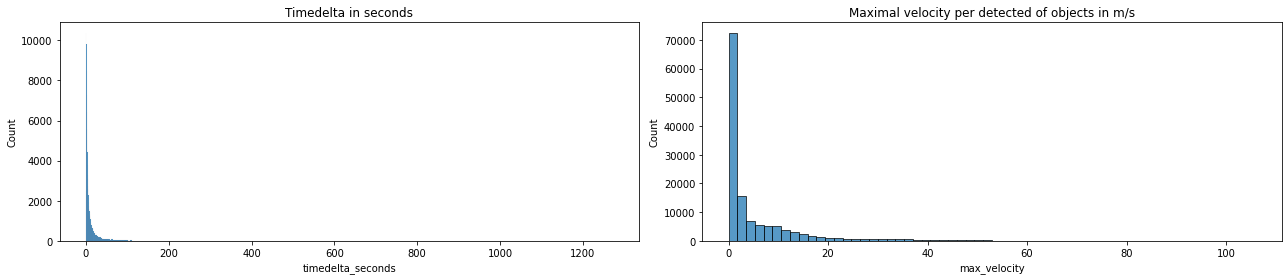

In [191]:
# histogram plots of time delta and velocity before any filtering
timedelta_df = data.groupby("id")["timestamp"].agg([min, max]).reset_index()
timedelta_df["timedelta"] = timedelta_df["max"] - timedelta_df["min"]
timedelta_df["timedelta_seconds"] = timedelta_df["timedelta"].dt.total_seconds()

data["velocity"] = np.sqrt(data["vel_x"]**2 + data["vel_y"]**2 +data["vel_z"]**2)
df_velocity = data.groupby("id")["velocity"].agg([np.max]).reset_index()
df_velocity.columns=  ["id","max_velocity"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
sns.histplot(timedelta_df, x="timedelta_seconds",ax=ax[0], bins="auto")
sns.histplot(df_velocity, x="max_velocity",ax=ax[1], bins=60)
ax[0].set_title("Timedelta in seconds") 
ax[1].set_title("Maximal velocity per detected of objects in m/s") 
plt.tight_layout()
plt.show()

## Filtering on objects based on duration and speed

* We have to remove objects that do not respect a lower and an upper threshold of time stay in the intersection
they might be outlier or stationary objects. We set two thresholds: 
    1. Maximal time stay is **20 minutes** which is could be represent traffic jam (for cars). We consider that a pedestrian or a cyclist will not stay more than 20 minutes also at an intersection unless there is a bus station ..
    
    2. Minimum time stay is around **10 seconds** which corresponds to the duration that a car will take to pass 140 m  at 50km/h (which is the maximal speed authorized in urban areas). The replay shows that 10 second is an acceptable threshold to set the minimum time of stay an object in the intersection.


* We want have to remove objects whose **maximal detected speed is less than 1 m/s** which corresponds to the speed of human being while walking which is the slowest valid object that we can have on the road in our situation. The velocity is calculated using this formula: 

                            velocity = √(vel_x² + vel_y² + vel_z²)

In [192]:
list_objects_to_be_removed = []
# removing objects according to their time stay
max_duration = 1200  
min_duration = 10 
selected_ids_time_stay = timedelta_df[(timedelta_df['timedelta_seconds'] < max_duration) &\
(timedelta_df['timedelta_seconds'] > min_duration)]["id"].values.tolist()
list_objects_to_be_removed.append(data[~data["id"].isin(selected_ids_time_stay)])
data = data[data["id"].isin(selected_ids_time_stay)]

# removing objects according to their speed
selected_ids_speed = df_velocity[df_velocity['max_velocity'] > 1]["id"].values.tolist()
list_objects_to_be_removed.append(data[~data["id"].isin(selected_ids_speed)])
data = data[data["id"].isin(selected_ids_speed)]

df_to_be_removed = pd.concat(list_objects_to_be_removed).reset_index(drop=True)

# total number of objects without any cleaning or processing at the intersection
print("""After applying two filters on the data, the total number of objects at the intersection between 11am and 1pm on Monday 14 Octobre 2024 is: {nb_objects} """.
      format(nb_objects = data["id"].nunique()))

After applying two filters on the data, the total number of objects at the intersection between 11am and 1pm on Monday 14 Octobre 2024 is: 25222 


## EDA of non valid objects

In [150]:
def unify_labels_for_same_object(df):
    try:
        # based on confidence value, > 0.8
        label = df.loc[df[df["confidence"]>0.8].index,"label"].unique()[0] 
    except:
        # based on mode
        label = df["label"].mode()[0]
    df["label"] = label
    return df

list_df_id_label= [unify_labels_for_same_object(df) for _,df in df_to_be_removed.groupby("id")]
df_to_be_removed = pd.concat(list_df_id_label).reset_index(drop=True)
label_proportions_to_be_removed = df_to_be_removed.groupby('id')['label'].value_counts(normalize=True).index    
label_proportions_to_be_removed = pd.DataFrame(label_proportions_to_be_removed.values.tolist(),
                                 columns=["id","label"])["label"].value_counts(normalize=True)*100
display(label_proportions_to_be_removed)

LABEL_MISC         62.21161
LABEL_CAR          24.67353
LABEL_PEDESTRIAN   11.62493
LABEL_CYCLIST       1.48993
Name: label, dtype: float64

# Dealing with valid objects
After applying two filters on the data, the total number of objects at the intersection between 11am and 1pm on Monday 14 Octobre 2024 is: 25222

## Insights and observations on categorical variables
* **Some objects has more than one label in the dataframe**. To handle this issue, for each id, we set two rules:
    1. Get the label with the confidence level that is greater than 0.8
    2. If no label has a confidence label greater than 0.8, take the mode of the all labels of the same id



In [193]:
def unify_labels_for_same_object(df):
    try:
        # based on confidence value, > 0.8
        label = df.loc[df[df["confidence"]>0.8].index,"label"].unique()[0] 
    except:
        # based on mode
        label = df["label"].mode()[0]
    df["label"] = label
    return df

list_df_id_label= [unify_labels_for_same_object(df) for _,df in data.groupby("id")]
data = pd.concat(list_df_id_label).reset_index(drop=True)

Unique values in tracking: ['TRACKING', 'DRIFTING']


LABEL_CAR          60.60979
LABEL_PEDESTRIAN   22.44073
LABEL_MISC         13.66664
LABEL_CYCLIST       3.28285
Name: label, dtype: float64

TRACKING   93.21564
DRIFTING    6.78436
Name: tracking, dtype: float64

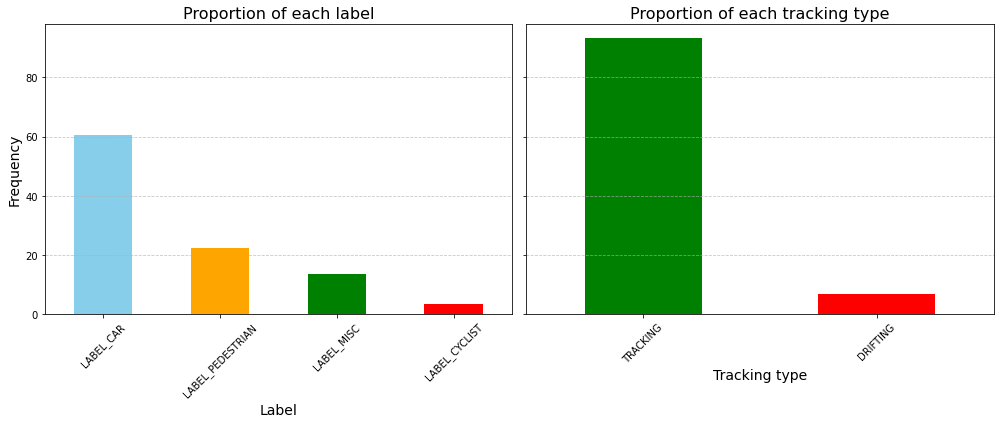

In [194]:
# checking possible values of categorical variables 
for col in data.select_dtypes(include='category'):
    print("Unique values in {col}: {values}".format(col=col, values= data[col].unique().tolist()))
    
# computing relative frequency of each possible value for label and tracking type
label_proportions = data.groupby('id')['label'].value_counts(normalize=True).index    
label_proportions = pd.DataFrame(label_proportions.values.tolist(),
                                 columns=["id","label"])["label"].value_counts(normalize=True)*100
tracking_type_proportions = data['tracking'].value_counts(normalize=True)*100
display(label_proportions)
display(tracking_type_proportions)

# creating barcharts for label and tracking
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
label_proportions.plot(kind='bar', color=['skyblue', 'orange', 'green', 'red'], ax=axes[0])
axes[0].set_title('Proportion of each label', fontsize=16)
axes[0].set_xlabel('Label', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

tracking_type_proportions.plot(kind='bar', color=['green', 'red'], ax=axes[1])
axes[1].set_title('Proportion of each tracking type', fontsize=16)
axes[1].set_xlabel('Tracking type', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Approximately 13% of the labels correspond to unspecified objects**, which is a significant proportion. In order to estimate the label, we will construct a classifier (*RandomForestClassifier*) that predicts whether it is a car, pedestrian or cyclist based on the *size*, *velocity* and *points_n* of the object. The classifier will be trained only on observations where label is  car, pedestrian or cyclist.

**But first we have to explore numerical variables that will be used as features during model training.**

## Exploratory Data Analysis for numerical variables

In [195]:
# describe to get some stats about numerical variables
df_describe = data.describe()
numerical_columns = [col for col in df_describe.columns if col != "id"]
display(df_describe)

,id,confidence,pos_x,pos_y,pos_z,size_x,size_y,size_z,vel_x,vel_y,vel_z,yaw,yaw_rate,points_n,velocity
count,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000,8109766.00000
mean,1776510.40800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,170.39343,NaN
std,160658.21540,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,319.48243,0.00000
min,1477200.00000,0.10999,-166.25000,-122.68750,0.00000,0.00000,0.00000,0.00000,-98.62500,-73.62500,0.00000,0.00000,-6.28125,0.00000,0.00000
25%,1635421.00000,0.50000,-44.00000,-32.28125,0.00000,0.66992,0.43994,0.75000,-0.97998,-0.08002,0.00000,2.70508,-0.03000,18.00000,0.03000
50%,1782065.00000,0.81982,-24.12500,-19.59375,0.00000,3.98047,1.82031,1.45020,-0.02000,-0.00000,0.00000,3.15430,0.00000,57.00000,0.33521
75%,1914671.00000,0.95020,20.89062,-5.67188,0.00000,4.55859,1.95996,1.79980,0.03000,0.03000,0.00000,4.39844,0.01000,213.00000,1.94238
max,2046920.00000,1.95996,113.06250,71.50000,3.42969,21.20312,20.95312,3.50000,45.09375,70.56250,0.00000,6.28125,6.28125,11625.00000,98.68750


In [196]:
def plot_histograms(data,numerical_columns):
    # histogram of numerical variables for each label (cars, pedestrian, cyclist)
    possible_labels = data["label"].unique()
    colors = ['orange', 'green', 'skyblue','red']
    for i, num_col in enumerate(numerical_columns):
        fig, axes = plt.subplots(nrows=1, ncols=len(possible_labels), figsize=(18, 5))
        for j, label in enumerate(possible_labels):
            subset = data[data["label"] == label]     
            sns.histplot(subset, x=num_col, kde=True, ax=axes[j], color=colors[j], bins=40)
            axes[j].set_title("{num_col} - {label}".format(num_col=num_col,label=label))

    plt.tight_layout()
    plt.show()
    
def plot_boxplots(data,numerical_columns):
    # boxplots of numerical variables for each label (MISC, cars, pedestrian, cyclist)
    possible_labels = data["label"].unique()
    colors = ['orange', 'green', 'skyblue','red']
    for i, num_col in enumerate(numerical_columns):
        fig, axes = plt.subplots(nrows=1, ncols=len(possible_labels), figsize=(18, 5))
        for j, label in enumerate(possible_labels):
            subset = data[data["label"] == label]
            sns.boxplot(data=subset, y=num_col, ax=axes[j], color=colors[j],whis=10)
            axes[j].set_title("{num_col} - {label}".format(num_col=num_col,label=label))
    plt.tight_layout()
    plt.show()
    
    
numerical_columns = ["size_x","size_y","size_z","vel_x","vel_y","vel_z","yaw","yaw_rate"]
# hist plots and box plots
plot=False # set to false to avoid plotting when testing
if plot:
    plot_histograms(data,numerical_columns)
    plot_boxplots(data,numerical_columns)

### Insights on Numerical Variables

1. Some values of `confidence` are greater than 1. These should be capped at 1, as confidence values typically range from 0 to 1.

2. `pos_x` and `pos_y` appear to represent the coordinates of objects within the intersection. The values are both negative and positive, indicating that the objects are distributed around the origin. Some `pos_z` values are not zero.They might be outliers since the objects are expected to be on the ground.

3. Some values in `size_x`, `size_y` and `size_z` are abnormal specially for pedestrians and cyclists. If the label is correct (e.g. Pedestrian, cyclist or car) we can detect them using IQR (interquartile range) method then replace them with the median of each distribution. 

4. No specific remarks on `vel_x` and `vel_y` as they are centered around zero, which is normal for an intersection where objects runs at opposite directions. `vel_z` is always zero as expected. The unit is `m/s`. 

5. The distribution of `yaw` is expected to be like this. Values close to 0 and 6.28 correspond to 0° and 360° (the same direction), values around 3.14  correspond to the opposite direction (180° or π), and values near 1.5 and 4.71 (π/2 and 3π/2) correspond to standard turns (90° and 270°).

### Detecting and Replacing Outliers with the Median 
Each label (car, pedestrian, cyclist) has been handled separately. InterQuartile Range method is used to detect outliers.

In [197]:
def replace_outliers(data_object,variables_to_handle):
    for col in variables_to_handle:
        Q1 = data_object[col].quantile(0.25)
        Q3 = data_object[col].quantile(0.75)
        IQR = Q3 - Q1
        coefficient = 3
        lower_bound = Q1-coefficient*IQR
        upper_bound = Q3+coefficient*IQR
        median_value = data_object[col].median()
        data_object.loc[:,col] = data_object.loc[:,col].apply(lambda x: median_value 
                                                  if x < lower_bound or x > upper_bound else x)
    return data_object

data["confidence"] = data["confidence"].clip(lower= 0, upper=1) # cap confidence level to 1
data["pos_z"] = 0 # set pos_z to 0
data["vel_z"] = 0 # set vel_z to 0

data_misc = data[data["label"] == "LABEL_MISC"]
data_pred = data[data["label"] == "LABEL_PEDESTRIAN"]
data_car = data[data["label"] == "LABEL_CAR"]
data_cyclist = data[data["label"] == "LABEL_CYCLIST"]

variables_to_handle = ["size_x","size_y","size_z","vel_x","vel_y"]

list_data_objects = []
for data_object in [data_pred,data_car, data_cyclist]:
    list_data_objects.append(replace_outliers(data_object,variables_to_handle))
list_data_objects.append(data_misc)

data = pd.concat(list_data_objects).reset_index(drop=True)
plot=False # set to false to avoid plotting when testing
if plot:
    plot_histograms(data,numerical_columns)

### Building the model
In order to estimate the label, we will construct a classifier (*RandomForestClassifier*) that predicts whether it is a car, pedestrian or cyclist based on the *size*, *velocity* and *points_n* of the object.

When building the model we should take into consideration that the dataset is **imbalanced**, (**among non miscellaneous** objects 70% of objects are cars, 26% are pedestrian and 4% are cyclists). To that end, we set the **class_weight parameter to "balanced"** in random forest classifier and we use **stratified kfold validation** in order to respect target distribution in each fold split.

AUC-ROC (macro average): 0.9984029090526237


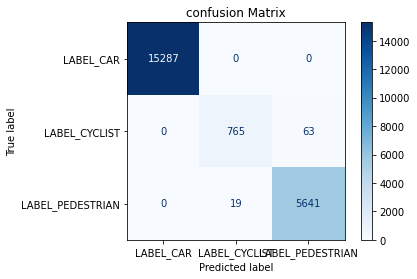

RandomForestClassifier(class_weight='balanced', random_state=42)

In [201]:
features = ["size_x", "size_y", "size_z", "vel_x", "vel_y", "points_n"]
data_not_misc = data[data["label"] != "LABEL_MISC"]
grouped_data = data_not_misc.groupby("id")

# Select the mode of the label for each group
targets = [gp["label"].mode().values[0] for _, gp in grouped_data]
dataset = pd.concat(
    [pd.DataFrame(gp[features].mean(axis=0).values.reshape(1, -1)) for _, gp in grouped_data], 
    ignore_index=True)
dataset['target_label'] = targets

X = dataset.values[:,:6]  # selecting features (first 6 columns)
y = dataset['target_label']  

# encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# we use class weight parameter and stratified_Kfold validation in order to handle imbalanced target labels
model = RandomForestClassifier(class_weight='balanced', random_state=42)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_prob = np.zeros((y_encoded.shape[0], len(np.unique(y_encoded))))
for train_idx, test_idx in stratified_kfold.split(X, y_encoded):
    model.fit(X[train_idx], y_encoded[train_idx])
    y_prob[test_idx] = model.predict_proba(X[test_idx])


auc_roc = roc_auc_score(y_encoded, y_prob, multi_class='ovo', average='weighted')
print("AUC-ROC: {auc_roc}".format(auc_roc=auc_roc))
y_pred = cross_val_predict(model, X, y_encoded, cv=stratified_kfold)

cm = confusion_matrix(y_encoded, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("confusion Matrix")
plt.show()

# retraining on full dataset to be used for prediction
model.fit(X, y)

### Applying the model to estimate miscellaneous labels

LABEL_CAR          0.60737
LABEL_PEDESTRIAN   0.34771
LABEL_CYCLIST      0.04492
Name: label, dtype: float64

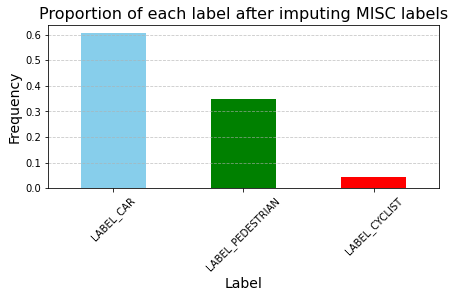

LABEL_PEDESTRIAN    3110
LABEL_CYCLIST        305
LABEL_CAR             32
Name: label, dtype: int64

In [13]:
# applying the model on objects whose label is MISC
data_misc = data[data["label"] == "LABEL_MISC"]
data_not_misc = data[data["label"] != "LABEL_MISC"]
grouped_data = data_misc.groupby("id")

# averaging features of the same id accross all timestamps
dataset_misc = [(id_, gp[features].mean(axis=0).values.reshape(1, -1)) for id_, gp in grouped_data]
list_predictions_misc = [(id_, model.predict(feature_vector)[0]) for id_,feature_vector in dataset_misc]
df_predictions_misc = pd.DataFrame(list_predictions_misc,columns=["id","label"])

id_to_label = df_predictions_misc.set_index("id")["label"]
data["label"] = data["id"].map(id_to_label).combine_first(data["label"])

# computing relative frequency of each possible value for label after dealing with misc values
label_proportions = data.groupby('id')['label'].value_counts(normalize=True).index    
label_proportions = pd.DataFrame(label_proportions.values.tolist(),
                                 columns=["id","label"])["label"].value_counts(normalize=True)    
display(label_proportions)

# creating barcharts for label after imputing misc labels
fig, axes = plt.subplots(figsize=(7, 3), sharey=True)
label_proportions.plot(kind='bar', color=['skyblue',  'green', 'red'], ax=axes)
axes.set_title('Proportion of each label after imputing MISC labels', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Frequency', fontsize=14)
axes.tick_params(axis='x', rotation=45)
axes.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
display(df_predictions_misc["label"].value_counts())

### Insights on predictions
**Among 3447 miscellaneous objects, the model predicted 3110 (90%) as pedestrians, 305 as cyclists (8%) and 32 (2%) as cars.**

In [ ]:
#Bucketizing timestamps into 100ms interval buckets
data["bucketized_timestamp"] = data['timestamp'].dt.floor('100ms')

# Theoretical Approach for Near Misses Detection
Traffic near-miss incidents are dangerous scenarios where potential collisions between vehicles, pedestrians, or other vehicles are narrowly avoided due to driver interventions or timing differences. Analyzing these incidents is critical for enhancing the safety of self-driving vehicles, as the frequency of near misses is directly linked to the likelihood of accidents and fatalities.

### 1. Bucketizing timestamps into 100ms interval buckets

To deal with near misses, we define an approach that is based on pairwise computation of different objects. In the provided data, we observed that timestamps are not unique for all objects. Thus, we decided to bucketize the timestamps into 100ms intervals. Every observation timestamp will be affected to 100 ms bucket, and if more than one observation for the same object are present in the same bucket, their features should be merged. 

### 2. Near misses incidents definition
One way to detect near misses incidents is to use surrogate safety measures such like Time To Collision (TTC) which is defined as the time between is the time between a predicted collision at current speed and position.
Another widley used metric is Post Encroachment Time (PET), defined as the time difference between two road users overlapping at any point. For intersections, where road users regularly cross trajectories, PET is a well-established method for safety evaluation [Weide, 2024](https://essay.utwente.nl/98720/1/van%20der%20Weide_MA_EEMCS.pdf). 

However, in this project, we will focus on detecting near misses events based on TTC.

The proposed approach consists in analyzing for every bucketized timestamp (every 100ms), motions of all pairs of objects that are presented at the intersection (Cars-Pedestrians, Cars-Cyclists, Cars-Cars) and to compute a time to collision measure TTC for each of the pairs and timestamps. Then, some rules are applied to classify the situation as near miss or not. 

In the next sections, we present how to detect a near miss situation for two objects at a timestamp $t$. However, to have a complete insight on the intersection zone, we should do the same analysis for all pairs of objects at each timestamp.


### 3. Motion Analysis of two objects

#### Relative position at each bucktized timestamp
At each bucketized timestamp $t$, calculate the relative position between the two objects:

$$\Delta x(t) = pos_{x1}(t) - pos_{x2}(t) \\ \Delta y(t) = pos_{y1}(t) - pos_{y2}(t)$$

Where:
$(pos_{x1}(t), pos_{y1}(t))$ and $(pos_{x2}(t), pos_{y2}(t))$ are the positions of *Object1* and *Object2* at time $t$, respectively.

#### Relative velocity at each bucktized timestamp
Similarly, calculate the relative velocity at each bucketized timestamp $t$ using the velocity components

$$\Delta v_x(t) = vel_{x1}(t) - vel_{x2}(t) \\ \Delta v_y(t) = vel_{y1}(t) - vel_{y2}(t)$$ 


Where:
$(vel_{x1}(t), vel_{y1}(t))$ and $(vel_{x2}(t), vel_{y2}(t))$ are the velocities of *Object1* and *Object2* at time $t$, respectively.


#### Time to Collision (TTC) at each bucktized timestamp

Calculate the **Time to Collision (TTC)** using the relative position and relative velocity at each bucktized timestamp. If the relative velocity is not zero
, calculate the TTC as:

$$TTC(t) = \frac{\text{Distance$_{center-center}$}(t)}{\text{Relative Velocity}(t)}$$

Where:
- **Distance$_{center-center}$** is the Euclidean distance between the two objects positions at time $t$:
  $$\text{Distance$_{center-center}$}(t) = \sqrt{(\Delta x(t))^2 + (\Delta y(t))^2}$$
  
  
- **Relative Velocity** is the magnitude of the relative velocity:
  $$\text{Relative Velocity}(t) = \sqrt{(\Delta v_x(t))^2 + (\Delta v_y(t))^2}$$
  

### 4. Detection of Near Misses Based on Distance and TTC

After calculating the TTC at each time step, the following criteria is used to classify near misses:

#### Near Miss Criteria
- If the predicted distance between the two objects (based on current positions and velocities) is below a certain threshold  $d_{\text{critical}}$ and the TTC is below a 2 seconds, it’s considered a near miss.

$$
\text{If } \text{Distance$_{edge-edge}$}(t) < d_{\text{critical}} \quad \text{ and } \quad TTC(t) \leq 2  \quad \text{,then classify this as a near miss}
$$


#### Time to Collision (TTC) Range
The TTC threshold of 2 seconds is considered to include **high** ($TTC \leq 0.5$) and **intermediate** ($0.5 \leq TTC \leq 2$) collision risks, thus we classify those two situations as near misses [Weide, 2024](https://essay.utwente.nl/98720/1/van%20der%20Weide_MA_EEMCS.pdf) [Kataoka et al., 2018](https://arxiv.org/pdf/1804.02555).
* $TTC \leq 0.5 s$ $\longrightarrow$ <span style="color:red">high risk (**near miss**)</span> 
* $0.5 s < TTC \leq 2 s$ $\longrightarrow$ <span style="color:orange">intermediate risk  (**near miss**)</span> 
* $TTC  >2 s$ $\longrightarrow$ <span style="color:green">low risk</span> 


#### Critical Distance $(d_{\text{critical}})$
- This detection process should be take into consideration the objects sizes. To simplify we consider only 2D objects so we only (size_x and size_y), thus all objects are considered as rectangles with center (pos_x,pos_y) and sizes (size_x, size_y).

The critical distance $(d_{\text{critical}})$ is set to **1 meter** for all types of objects (cars, pedestrians, cyclists). In the context where the two objects could be:

* Aligned on the x axis ($yaw_1$ and $yaw_2$ ~ 0, 2$\pi$ or $\pi$ AND $pos_{y1}$~$pos_{y2}$) the distance is :
$$\text{Distance$_{edge-edge}$}(t) = \text{Distance$_{center-center}$}(t) - \frac{size_{x1}}{2} - \frac{size_{x2}}{2}$$
                       
                       
* Aligned on the y axis ($yaw_1$ and $yaw_2$ ~ $\frac{\pi}{2}$ or $\frac{3\pi}{2}$ AND $pos_{x1}$~$pos_{x2}$) the distance is :
$$\text{Distance$_{edge-edge}$}(t) = \text{Distance$_{center-center}$}(t) - \frac{size_{y1}}{2} - \frac{size_{y2}}{2}$$

* If the objects are not aligned, the corners of each rectangle should be calculated by including the $yaw$ measure and the rotation matrix


$$
R(\text{yaw}) = 
\begin{bmatrix}
\cos(\text{yaw}) & -\sin(\text{yaw}) \\
\sin(\text{yaw}) & \cos(\text{yaw})
\end{bmatrix}
$$



$$
x_{new} =  x_{old} \cdot \cos(\text{yaw}) - y_{old} \cdot \sin(\text{yaw})
$$

$$
y_{new} = x_{old} \cdot \sin(\text{yaw}) + y_{old} \cdot \cos(\text{yaw})
$$

where $(x_{old}, y_{old})$ are (pos$_x$+ $\frac{size_x}{2}$, pos$_y$+ $\frac{size_y}{2}$) for the top right corner (for example). We should do the same for the three remaining corners.

At this stage, we have for each object the x,y coordinates of its 4 corners. The next step is to compute the minimal distance between these two objects. There exists some algorithmes such as 


### 5. Limitations and Prespectives